In [329]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression
import seaborn as sb
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, confusion_matrix
from math import sqrt 
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import itertools
from itertools import combinations
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV # used for an exhaustive search
from sklearn.ensemble import GradientBoostingRegressor
sb.set()

<p style="font-size: 50px">CONCEPTUAL</p>
<p>1</p>

<AxesSubplot: xlabel='X'>

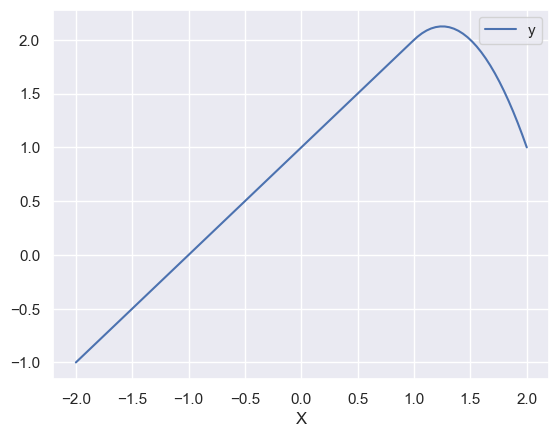

In [314]:
#conceptual 1
X = np.linspace(-2, 2, 100)
df = pd.DataFrame(X, columns = ['X'])
df['y'] = 1 + df['X'] #beta 0
df['y'] += (-2*(df['X']-1)**2)*(df['X']>=1).mul(1)
df.plot(x='X', y='y')

<p>Y intercept: 1<br>
X intercept: none in the specified range.<br>
The curve is linear between X= -2, and X=1 with the equation y=1+x and then turns into a quadratic equation between X=1 and X=2 with the equation of the line being  y=1+x−2(x−1)<sup>2</sup></p>

2

<AxesSubplot: xlabel='X'>

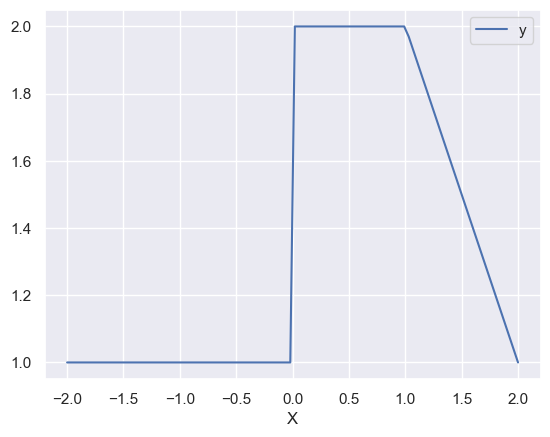

In [315]:
#conceptual 1
X = np.linspace(-2, 2, 100)
df = pd.DataFrame(X, columns = ['X'])


b1 = df['X'].between(0,2,'both').mul(1) - (df['X']-1)*(df['X'].between(1,2,'both').mul(1))
b2 = (df['X']-3)*df['X'].between(3,4,'both').mul(1) + df['X'].between(4,5,'right').mul(1)
df['y'] = 1 + b1 + 3*b2 #beta 0
df.plot(x='X', y='y')

There is a y intercept at Y=1
There are no x intercepts in the given range. 
The slope for this function is 0 for -2 to 0, and 0 to 1.
The slope for this function is extremely high near X=0
The slope of this function is 1+1-(X-1) from 1 to 2.

<p style="font-size:40px">Applied</p>

1.
1a.

Degree with best fit: 3 R^2 value: 0.08355308128270975


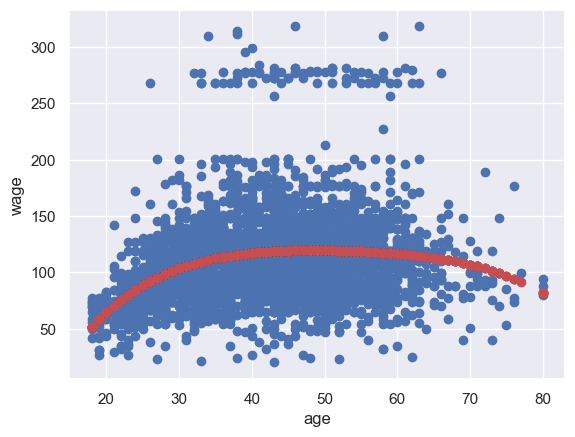

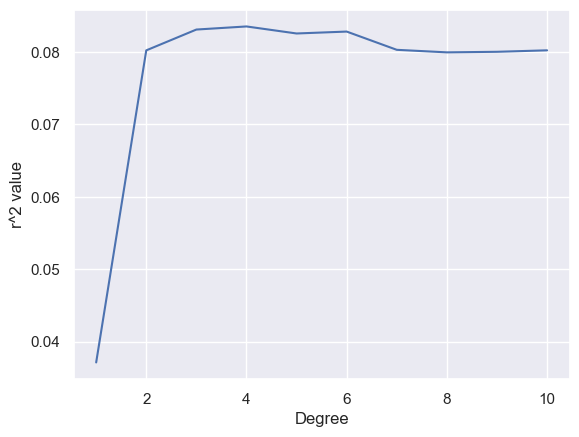

In [316]:
df = pd.read_csv("Wage.csv")
X = df['age'].values.reshape(-1,1)
y = df['wage']
plt.scatter(X, y)
scores = []
for i in range(1, 11):
    p = make_pipeline(PolynomialFeatures(i), LinearRegression())
    scores.append(np.mean((cross_val_score(p, X, y, cv=5, scoring='r2'))))
print("Degree with best fit:",np.argmax(scores), "R^2 value:",max(scores))
p = make_pipeline(PolynomialFeatures(np.argmax(scores)+1), LinearRegression())
p.fit(X, y)
ypred = p.predict(X)
plt.scatter(X, ypred, color='r')
plt.xlabel('age')
plt.ylabel('wage')
plt.show()
plt.plot(list(range(1, len(scores)+1)), scores)
plt.ylabel("r^2 value")
plt.xlabel("Degree")
plt.show()


1b.

      1  2  3  4
0     1  0  0  0
1     1  0  0  0
2     0  1  0  0
3     0  1  0  0
4     0  0  1  0
...  .. .. .. ..
2995  0  1  0  0
2996  1  0  0  0
2997  1  0  0  0
2998  1  0  0  0
2999  0  0  1  0

[3000 rows x 4 columns]
40.51566991720739


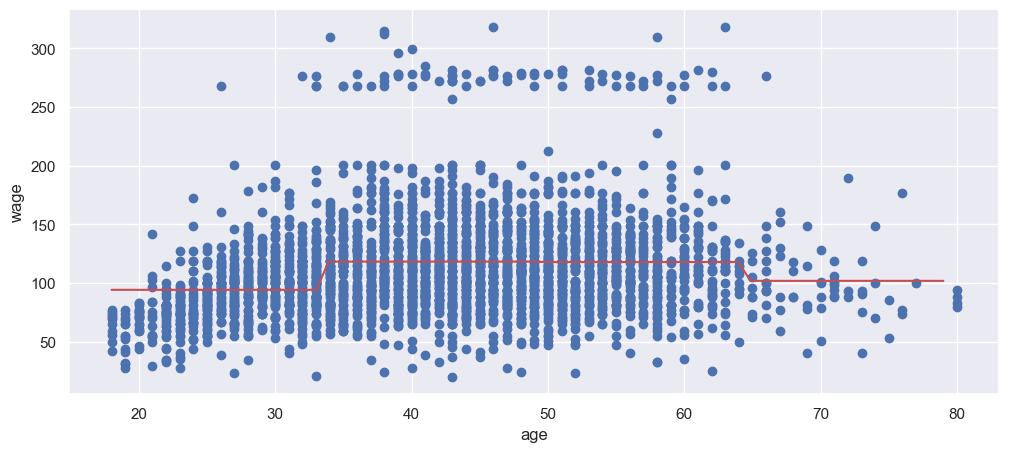

In [317]:
X=df['age']
df_cut, bins = pd.cut(X, 4, retbins=True, right=True)
df_steps = pd.concat([X, df_cut, y], keys=['age', 'age_cuts', 'wage'], axis=1)
df_steps_dummies = pd.get_dummies(df_cut)


fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
bin_mapping = np.digitize(X, bins)
X_valid = pd.get_dummies(bin_mapping)


# Removing any outliers
X_valid = pd.get_dummies(bin_mapping).drop([5], axis=1)
print(X_valid)
# Prediction
pred2 = fit3.predict(X_valid)

# Calculating RMSE
rms = sqrt(mean_squared_error(y, pred2)) 
print(rms) 


# We will plot the graph for 70 observations only
xp = np.linspace(X.min(),X.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping) 
pred2 = fit3.predict(X_valid_2)
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
# fig.suptitle('Piecewise Constant', fontsize=14)

# # Scatter plot with polynomial regression line
ax1.scatter(X, y)
ax1.plot(xp, pred2, c='r')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

0


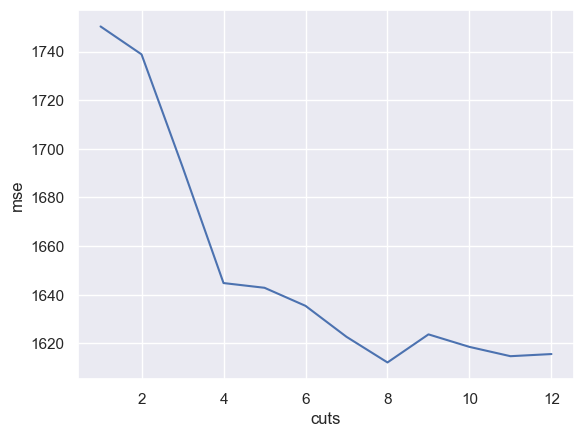

In [318]:
X=df['age']
y = df['wage']
all_mse=[]

pred2 =0
X_test =0
for i in range(1, 13):
    avg_mse = 0
    cnt = 0

    kf = KFold(n_splits=5, random_state=None)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        df_cut, bins = pd.cut(X_train, i, retbins=True, right=True) ###RANGE HERE
        df_steps = pd.concat([X_train, df_cut, y_train], keys=['age', 'age_cuts', 'wage'], axis=1)
        df_steps_dummies = pd.get_dummies(df_cut)


        fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

        bin_mapping = np.digitize(X_test, bins)
        
        # Removing any outliers
        
        X_valid = pd.get_dummies(bin_mapping).iloc[:,:i]#.drop([5], axis=1)
        
        # Prediction
        pred2 = fit3.predict(X_valid)

        # Calculating RMSE
        mse = mean_squared_error(y_test, pred2)
        avg_mse+=mse
        cnt+=1
    avg_mse/=cnt
    all_mse.append(avg_mse)

print(np.argmax(all_mse))
plt.plot(list(range(1, 13)), all_mse)
plt.xlabel('cuts')
plt.ylabel('mse')
plt.show()
# plt.scatter(X, y)
# plt.scatter(X_test, pred2, c='r')

# plt.xlabel('age')
# plt.ylabel('wage')
# plt.show()

The optimal number of steps is eight, as it gives us the lowest mse when performing cross-validation.

2.

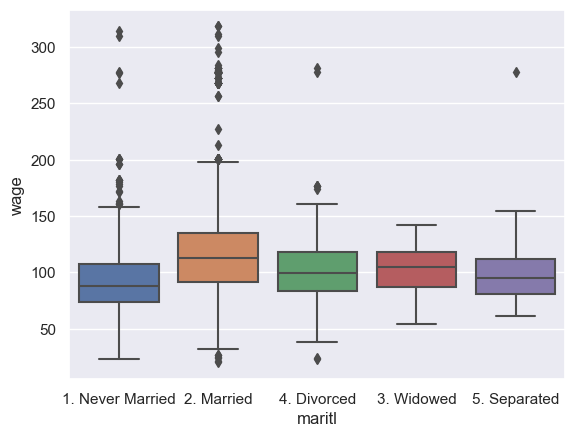

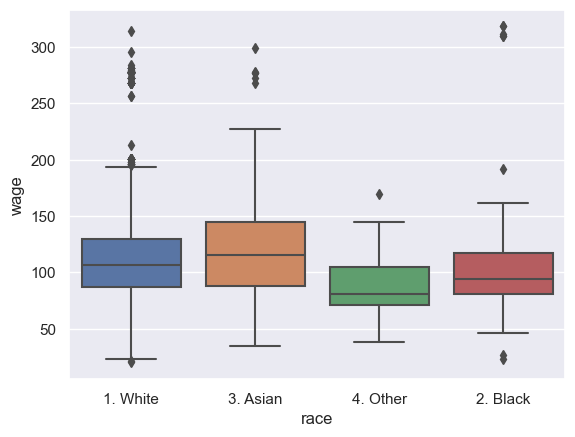

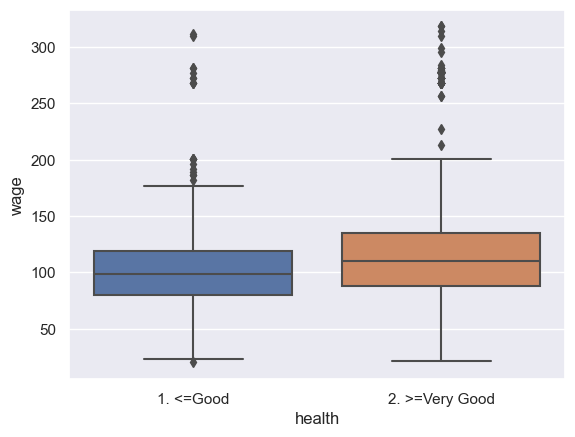

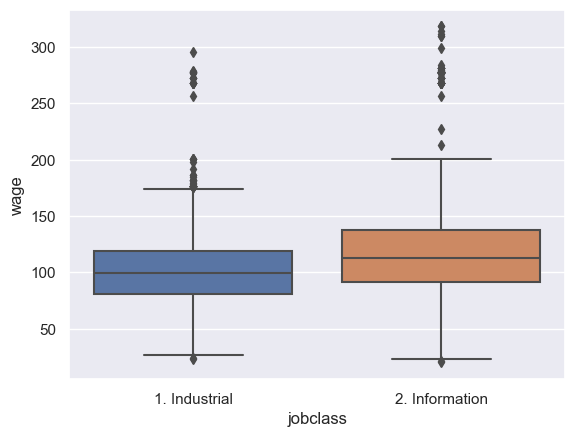

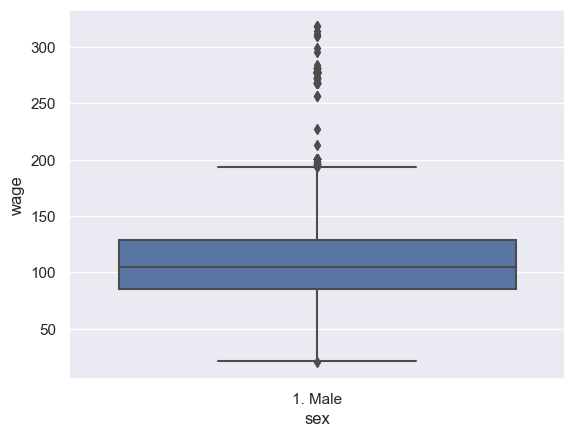

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [319]:
categoricals = ['maritl', 'race', 'health', 'jobclass','sex']
# print("maritl\n", df['maritl'].value_counts())
# print("race\n",df['race'].value_counts())
# print("health\n", df['health'].value_counts())
# print("jobclass\n", df['jobclass'].value_counts())
# print("sex\n", df['sex'].value_counts())

for i in categoricals:
    sb.boxplot(x=df[i],y=df['wage'])
    plt.show()


df.describe()

mean accuracy 0.021049328009272505
mse 1704.0547911511305


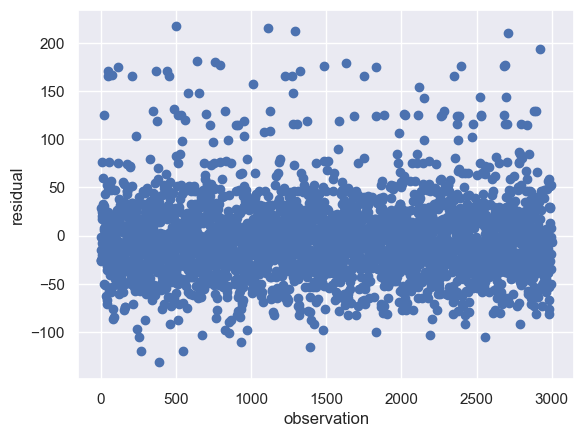

In [320]:
X = df[['maritl', 'race', 'health', 'jobclass', 'sex']]
X = pd.get_dummies(data=X)
y = df['wage']

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X, y)
ypred = knn.predict(X)
score = knn.score(X, y)
print("mean accuracy", score) #mean accuracy
print("mse", mean_squared_error(y, ypred))
ypred = pd.DataFrame(ypred, columns = ['pred'])
ypred['y'] = y
# print(ypred.to_string())
plt.scatter(ypred.index, ypred.y-ypred['pred'])
plt.xlabel("observation")
plt.ylabel("residual")
plt.show()

3.
3a.

coef [-0.18208169  0.02192766 -0.000885  ]
intercept 0.9341280720211884


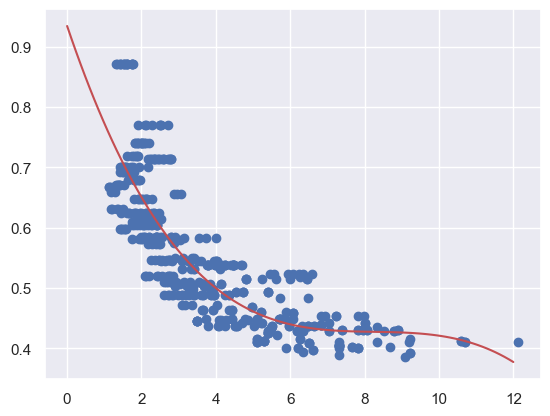

In [321]:
df = pd.read_csv('Boston.csv')
#pred = dis resp = nox
X= df['dis'].values.reshape(-1,1)
y =df['nox']
pip = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
pip.fit(X, y)
print("coef", pip[1].coef_[1:])
print("intercept", pip[1].intercept_)
space = np.linspace(0, 12, 100).reshape(-1,1)
ypred = pip.predict(space)
plt.scatter(X, y)
plt.plot(space, ypred, color="r")



3b.

Degree 1 RSS: 2.768562858969277


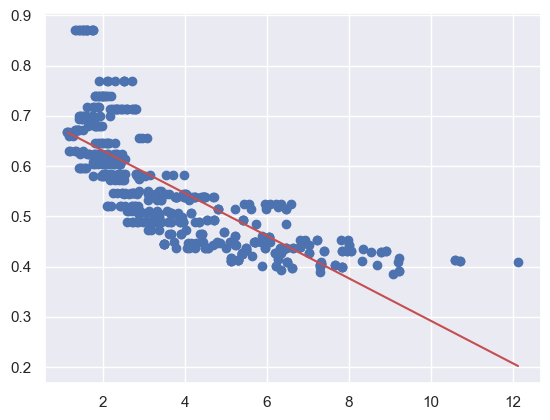

Degree 2 RSS: 2.0352618689352564


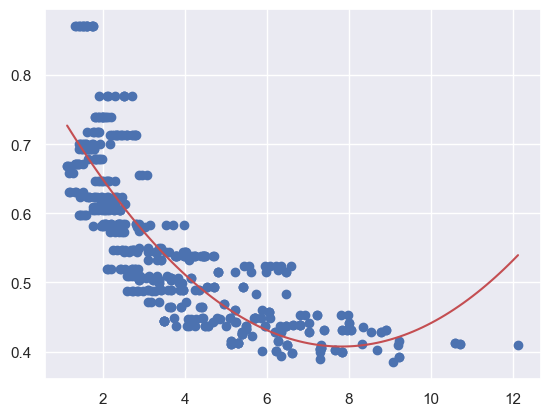

Degree 3 RSS: 1.9341067071790696


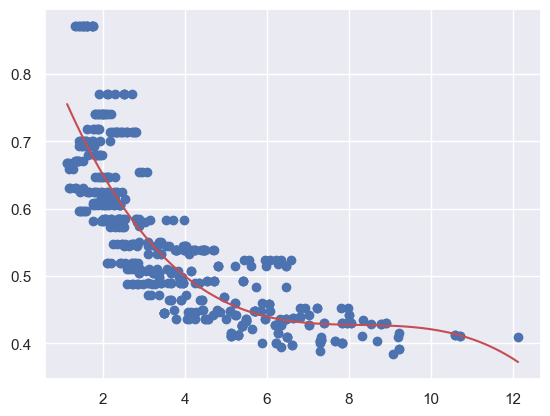

Degree 4 RSS: 1.932981327298597


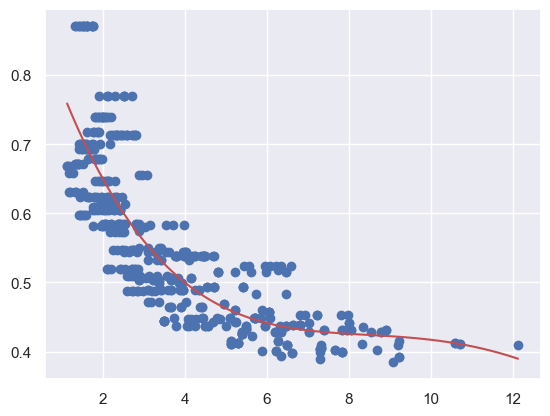

Degree 5 RSS: 1.9152899610843046


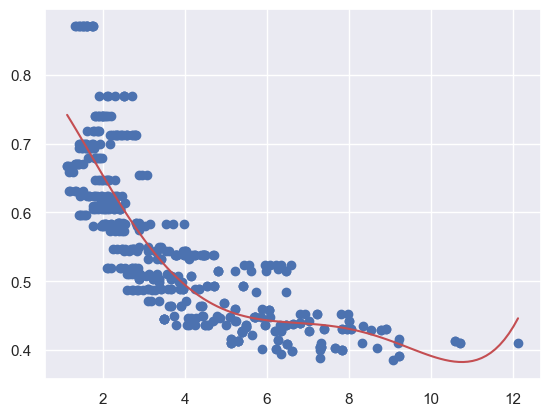

Degree 6 RSS: 1.8782572985081654


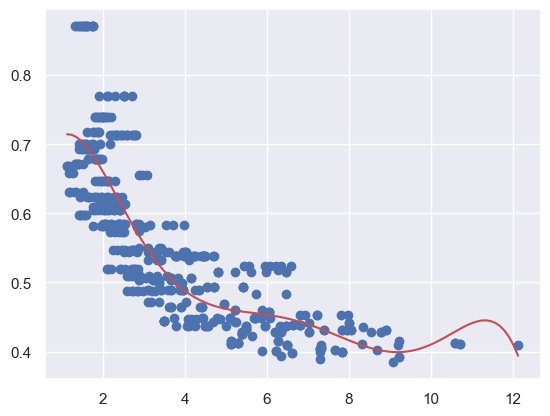

Degree 7 RSS: 1.8494836145829934


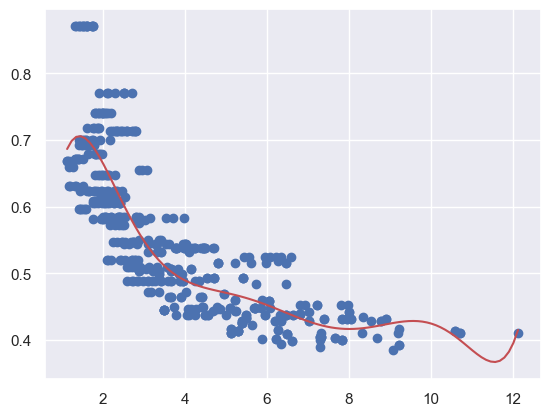

Degree 8 RSS: 1.8356296890675887


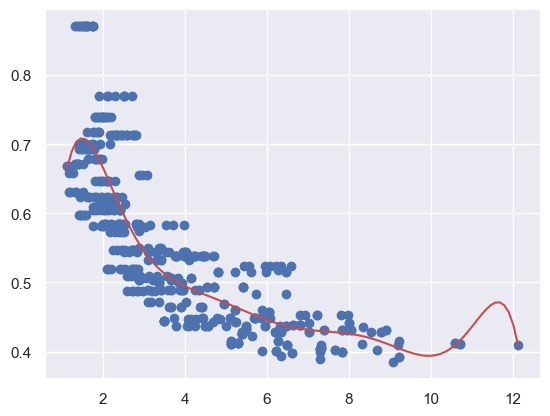

Degree 9 RSS: 1.8333308045143748


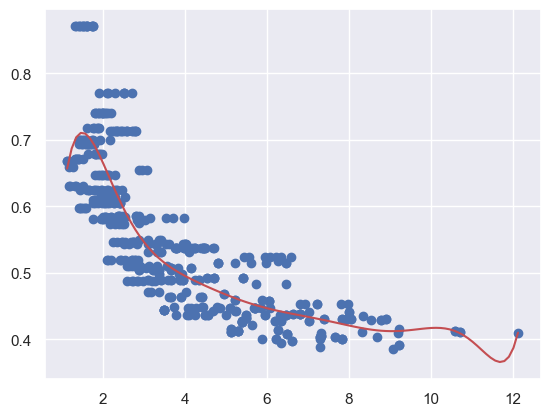

Degree 10 RSS: 1.8321711274176111


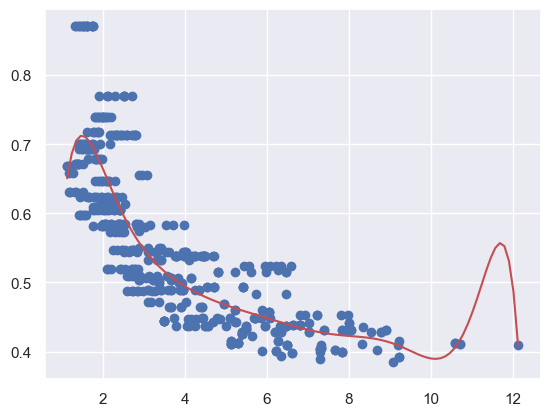

Degree with lowest RSS: 10


In [322]:
all_rss = []
space = np.linspace(min(X), max(X), 100).reshape(-1,1)
    
for i in range(1, 11):
    pip = make_pipeline(PolynomialFeatures(degree=i), LinearRegression())
    pip.fit(X, y)
    ypred = pip.predict(X)
    rss = sum((y-ypred)**2)
    all_rss.append(rss)
    print("Degree", i, "RSS:", rss)
    plt.scatter(X, y)
    ypred = pip.predict(space)
    plt.plot(space, ypred, color="r")
    plt.show()

print("Degree with lowest RSS:", np.argmin(all_rss)+1)

3c.

In [323]:
all_cv = []
for i in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=200)
    pip = make_pipeline(PolynomialFeatures(degree=i), LinearRegression())
    cv=cross_val_score(pip, X, y, cv=5, scoring='neg_mean_squared_error')
    all_cv.append(sum(cv)/len(cv))
for i, val in enumerate(all_cv):
    print("Degree:",i,"Avg Mean Squared Error:", -val)

print("Lowest MSE Degree:", np.argmax(all_cv)+1)
    

Degree: 0 Avg Mean Squared Error: 0.006032109223148159
Degree: 1 Avg Mean Squared Error: 0.004570384881436277
Degree: 2 Avg Mean Squared Error: 0.004647367459422983
Degree: 3 Avg Mean Squared Error: 0.004756118478674706
Degree: 4 Avg Mean Squared Error: 0.004969650255228574
Degree: 5 Avg Mean Squared Error: 0.02208332390018134
Degree: 6 Avg Mean Squared Error: 0.08601104447362791
Degree: 7 Avg Mean Squared Error: 2.4179944930280555
Degree: 8 Avg Mean Squared Error: 0.13094958662512546
Degree: 9 Avg Mean Squared Error: 84.65187016629548
Lowest MSE Degree: 2


According to the cross validation, degree 2 had the lowest average mean squared error across the our cross validation instances. 

3d.

In [324]:
# X = df['dis']
# df_cut, bins = pd.cut(X, 4, retbins=True, right=True)
# df_steps = pd.concat([X, df_cut, y], keys=['dis', 'dis_cuts', 'nox'], axis=1)
# df_steps_dummies = pd.get_dummies(df_cut)
# df_steps_dummies

# fit3 = sm.GLM(df_steps.nox, df_steps_dummies).fit()
# bin_mapping = np.digitize(X, bins)
# X_valid = pd.get_dummies(bin_mapping)
# # Removing any outliers
# X_valid = pd.get_dummies(bin_mapping).drop([5], axis=1)

# # Prediction
# pred2 = fit3.predict(X_valid)
# # Calculating RMSE

# rms = sqrt(mean_squared_error(y, pred2)) 
# print(rms) 


# # We will plot the graph for 70 observations only
# xp = np.linspace(X.min(),X.max()-1,70) 
# bin_mapping = np.digitize(xp, bins) 
# X_valid_2 = pd.get_dummies(bin_mapping) 
# pred2 = fit3.predict(X_valid_2)
# bins


In [325]:
# fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
# fig.suptitle('Piecewise Constant', fontsize=14)

# # Scatter plot with polynomial regression line
# ax1.scatter(X, y)
# ax1.plot(xp, pred2, c='r')

# ax1.set_xlabel('dis')
# ax1.set_ylabel('nox')
# plt.show()

parameters: Intercept                                      0.734474
bs(train, df=4, include_intercept=False)[0]   -0.058098
bs(train, df=4, include_intercept=False)[1]   -0.463563
bs(train, df=4, include_intercept=False)[2]   -0.199788
bs(train, df=4, include_intercept=False)[3]   -0.388809
dtype: float64


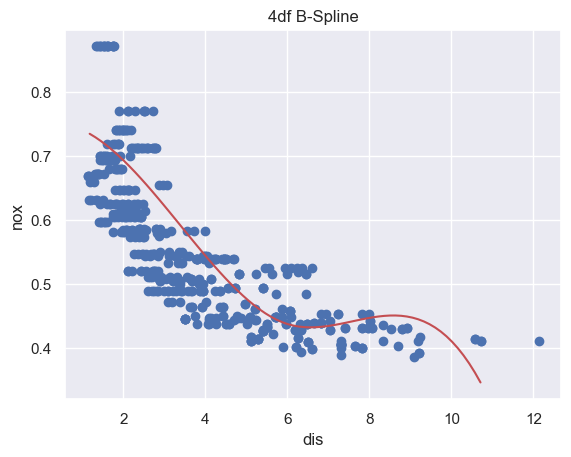

MSE: 0.0037999505786796947


In [326]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.33, random_state = 1)

# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, df=4, include_intercept=False)", {"train": X},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(y, transformed_x).fit()
print("parameters:",fit1.params)
# Predictions on splines
pred = fit1.predict(dmatrix("bs(valid, df=4, include_intercept=False)", {"valid": X}, return_type='dataframe'))
mse = mean_squared_error(y, pred)

xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred = fit1.predict(dmatrix("bs(continuous, df=4, include_intercept=False)", {"continuous": xp}, return_type='dataframe'))

plt.plot(xp, pred, c='r')
plt.scatter(X, y)
# # # Calculating RMSE values
# # rms1 = sqrt(mean_squared_error(valid_y, pred1))
# # print(rms1)

# # # We will plot the graph for 70 observations only


# # # Make some predictions
# # pred1 = fit1.predict(dmatrix("bs(xp, knots=(6.62805,9.377275), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# # # Plot the splines and error bands
# plt.scatter(df['dis'], df['nox'], facecolor='None', edgecolor='k', alpha=0.1)
# plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots')
# plt.legend()
plt.xlabel('dis')
plt.ylabel('nox')
plt.title('4df B-Spline')
plt.show()
print('MSE:',mse)

The knots were chosen by the software; we only supplied the degrees of freedom (4).

3e.

parameters: Intercept                                      0.755153
bs(train, df=3, include_intercept=False)[0]   -0.498271
bs(train, df=3, include_intercept=False)[1]   -0.233520
bs(train, df=3, include_intercept=False)[2]   -0.382680
dtype: float64


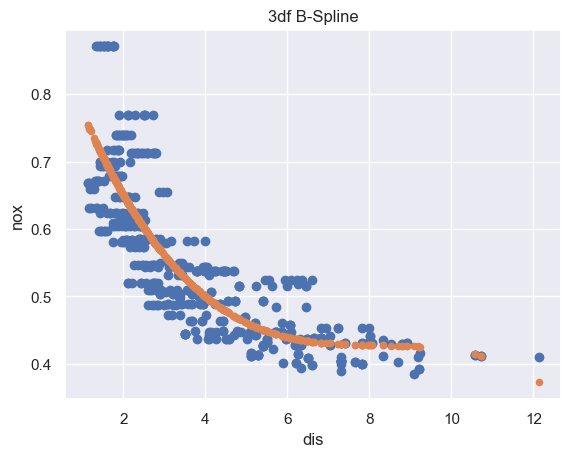

RMS: 0.06182511844796484
parameters: Intercept                                      0.734474
bs(train, df=4, include_intercept=False)[0]   -0.058098
bs(train, df=4, include_intercept=False)[1]   -0.463563
bs(train, df=4, include_intercept=False)[2]   -0.199788
bs(train, df=4, include_intercept=False)[3]   -0.388809
dtype: float64


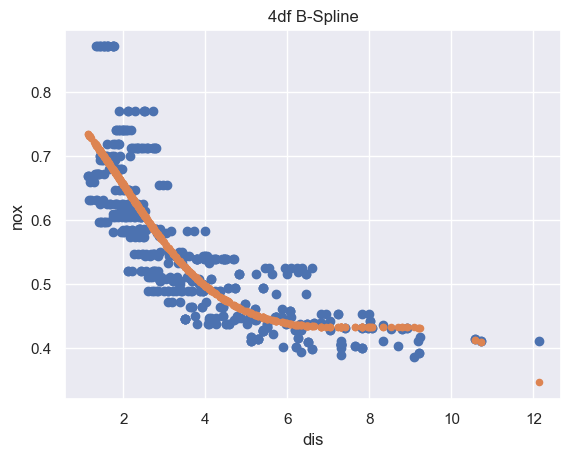

RMS: 0.061643739168545694
parameters: Intercept                                      0.672482
bs(train, df=5, include_intercept=False)[0]    0.083105
bs(train, df=5, include_intercept=False)[1]   -0.134604
bs(train, df=5, include_intercept=False)[2]   -0.255052
bs(train, df=5, include_intercept=False)[3]   -0.267850
bs(train, df=5, include_intercept=False)[4]   -0.261032
dtype: float64


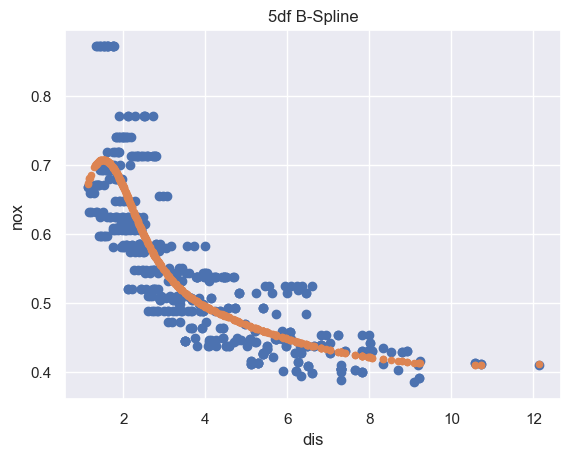

RMS: 0.06030510045826693
parameters: Intercept                                      0.656223
bs(train, df=6, include_intercept=False)[0]    0.102221
bs(train, df=6, include_intercept=False)[1]   -0.029629
bs(train, df=6, include_intercept=False)[2]   -0.159590
bs(train, df=6, include_intercept=False)[3]   -0.228147
bs(train, df=6, include_intercept=False)[4]   -0.262716
bs(train, df=6, include_intercept=False)[5]   -0.240025
dtype: float64


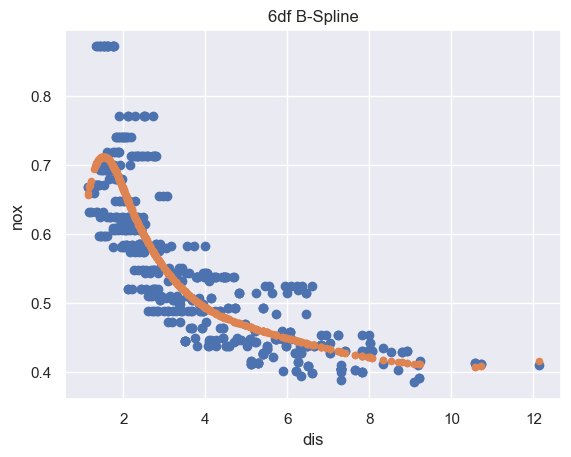

RMS: 0.060203310073407755
parameters: Intercept                                      0.645577
bs(train, df=7, include_intercept=False)[0]    0.112384
bs(train, df=7, include_intercept=False)[1]    0.024605
bs(train, df=7, include_intercept=False)[2]   -0.092162
bs(train, df=7, include_intercept=False)[3]   -0.162117
bs(train, df=7, include_intercept=False)[4]   -0.222239
bs(train, df=7, include_intercept=False)[5]   -0.248845
bs(train, df=7, include_intercept=False)[6]   -0.230906
dtype: float64


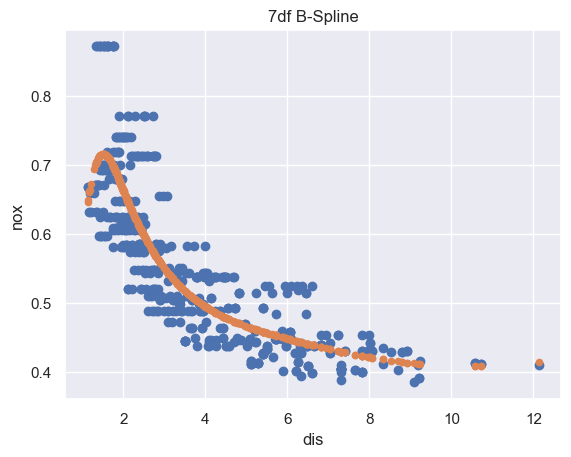

RMS: 0.06013628208305938
parameters: Intercept                                      0.632340
bs(train, df=8, include_intercept=False)[0]    0.139662
bs(train, df=8, include_intercept=False)[1]    0.036561
bs(train, df=8, include_intercept=False)[2]   -0.016564
bs(train, df=8, include_intercept=False)[3]   -0.134082
bs(train, df=8, include_intercept=False)[4]   -0.143783
bs(train, df=8, include_intercept=False)[5]   -0.236687
bs(train, df=8, include_intercept=False)[6]   -0.207703
bs(train, df=8, include_intercept=False)[7]   -0.228692
dtype: float64


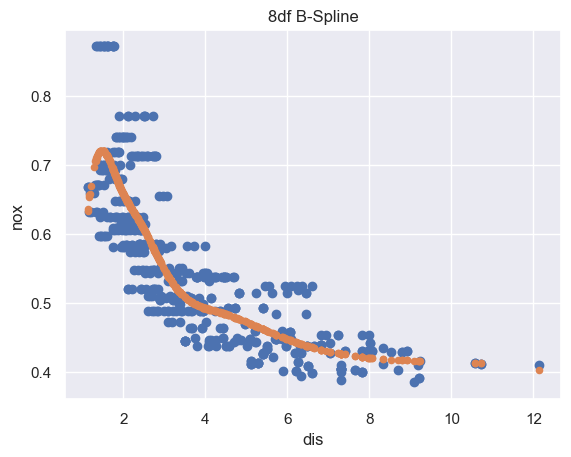

RMS: 0.05992411302298408
parameters: Intercept                                      0.633195
bs(train, df=9, include_intercept=False)[0]    0.130442
bs(train, df=9, include_intercept=False)[1]    0.053414
bs(train, df=9, include_intercept=False)[2]    0.004425
bs(train, df=9, include_intercept=False)[3]   -0.087034
bs(train, df=9, include_intercept=False)[4]   -0.133402
bs(train, df=9, include_intercept=False)[5]   -0.164008
bs(train, df=9, include_intercept=False)[6]   -0.221244
bs(train, df=9, include_intercept=False)[7]   -0.227141
bs(train, df=9, include_intercept=False)[8]   -0.221607
dtype: float64


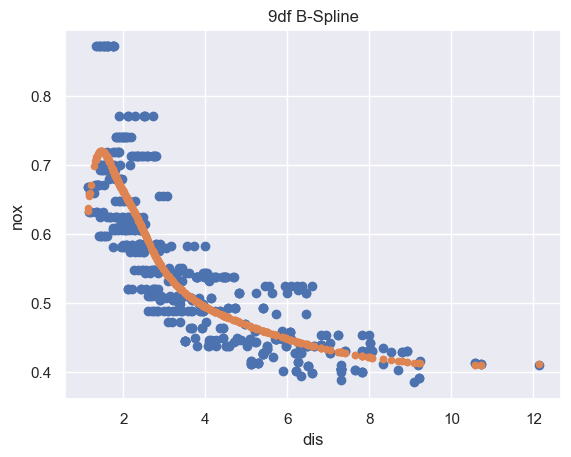

RMS: 0.06006670387001781
parameters: Intercept                                       0.645590
bs(train, df=10, include_intercept=False)[0]    0.078327
bs(train, df=10, include_intercept=False)[1]    0.090185
bs(train, df=10, include_intercept=False)[2]   -0.026983
bs(train, df=10, include_intercept=False)[3]   -0.019158
bs(train, df=10, include_intercept=False)[4]   -0.167579
bs(train, df=10, include_intercept=False)[5]   -0.123487
bs(train, df=10, include_intercept=False)[6]   -0.203886
bs(train, df=10, include_intercept=False)[7]   -0.199985
bs(train, df=10, include_intercept=False)[8]   -0.278184
bs(train, df=10, include_intercept=False)[9]   -0.219774
dtype: float64


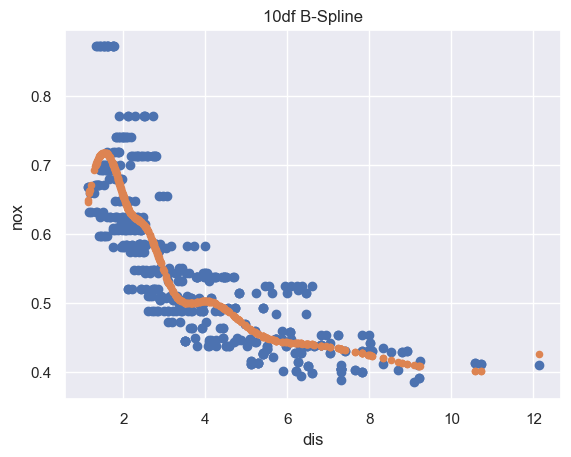

RMS: 0.05951940078889437


Text(0, 0.5, 'rms')

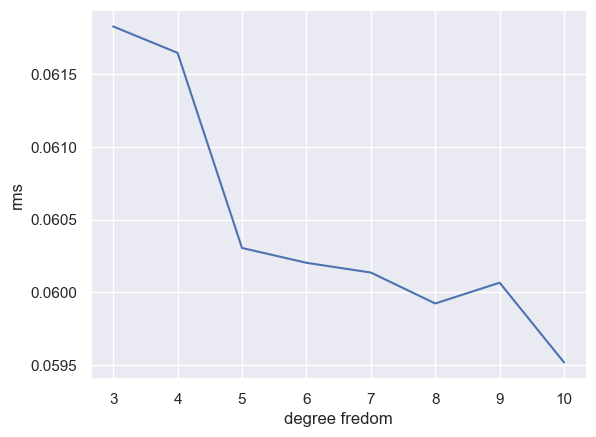

In [327]:
# train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.33, random_state = 1)
all_rms = []
for freedom in range(3, 11):
    # Generating cubic spline with 3 knots at 25, 40 and 60
    transformed_x = dmatrix("bs(train, df={}, include_intercept=False)".format(freedom), {"train": X},return_type='dataframe')

    # Fitting Generalised linear model on transformed dataset
    fit1 = sm.GLM(y, transformed_x).fit()
    print("parameters:",fit1.params)
    # Predictions on splines
    pred = fit1.predict(dmatrix("bs(valid, df={}, include_intercept=False)".format(freedom), {"valid": X}, return_type='dataframe'))
    rms = sqrt(mean_squared_error(y, pred))

   


    # xp = np.linspace(X.min(),X.max(),250)
    # pred = fit1.predict(dmatrix("bs(valid, df={}, include_intercept=False)".format(freedom), {"valid": xp}, return_type='dataframe'))

    # plt.plot(xp, pred, c='r')
    plt.scatter(X, y)
    plt.scatter(X, pred, s=20)
    # # # Calculating RMSE values
    # # rms1 = sqrt(mean_squared_error(valid_y, pred1))
 
    plt.xlabel('dis')
    plt.ylabel('nox')
    plt.title('{}df B-Spline'.format(freedom))
    plt.show()
    print('RMS:',rms)
    all_rms.append(rms)
plt.plot(list(range(3, 11)), all_rms)
plt.xlabel("degree fredom")
plt.ylabel("rms")

It seemed like the higher the degrees of freedom that we gave the model, the better it fit to existing data, and reduced the RMS. However, we must be wary of overfitting the more flexibility we give the model. 

3f.

7


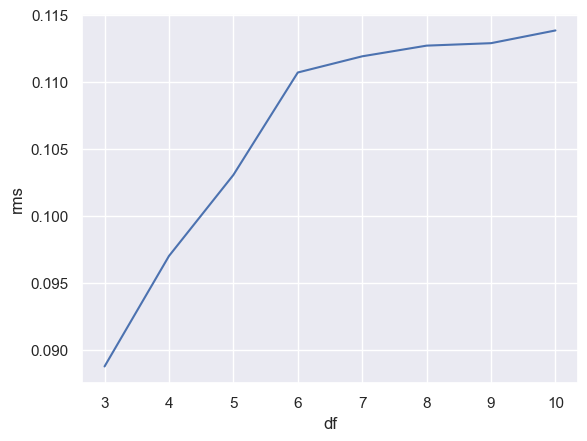

7


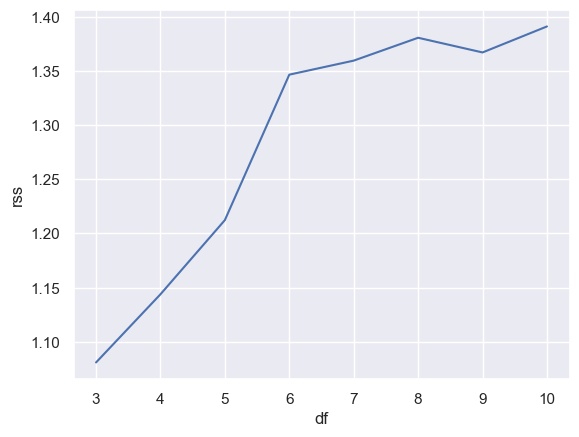

In [328]:
all_rms = []
all_rss = []
X = df['dis']
y = df['nox']
for freedom in range(3, 11):
    avg_rms = 0
    avg_rss =0
    cnt = 0

    kf = KFold(n_splits=5, random_state=None)
    for train_indices, test_indices in kf.split(X):
 
        X_train, X_test, y_train, y_test = X.iloc[train_indices], X.iloc[test_indices], y[train_indices], y[test_indices]
        # # Generating cubic spline
        transformed_x = dmatrix("bs(train, df={}, include_intercept=False)".format(freedom), {"train": X_train},return_type='dataframe')

        # # Fitting Generalised linear model on transformed dataset
        fit1 = sm.GLM(y_train, transformed_x).fit()
        # print("parameters:",fit1.params)
        # Predictions on splines
        pred = fit1.predict(dmatrix("bs(valid, df={}, include_intercept=False)".format(freedom), {"valid": X_test}, return_type='dataframe'))


        rms = sqrt(mean_squared_error(y_test, pred))
        rss = len(test_indices) * mean_squared_error(y_test, pred)
        avg_rms+=rms
        avg_rss+=rss
        cnt+=1
    avg_rms/=cnt
    avg_rss/=cnt
    all_rms.append(avg_rms)
    all_rss.append(avg_rss)


        # # xp = np.linspace(X.min(),X.max(),250)
        # # pred = fit1.predict(dmatrix("bs(valid, df={}, include_intercept=False)".format(freedom), {"valid": xp}, return_type='dataframe'))

        # # plt.plot(xp, pred, c='r')
        # plt.scatter(X, y)
        # plt.scatter(X, pred, s=20)
        # # # # Calculating RMSE values
        # # # rms1 = sqrt(mean_squared_error(valid_y, pred1))
    
        # plt.xlabel('dis')
        # plt.ylabel('nox')
        # plt.title('{}df B-Spline'.format(freedom))
        # plt.show()
        # print('RMS:',rms)
print(np.argmax(all_rms))
plt.plot(list(range(3, 11)), all_rms)
plt.xlabel('df')
plt.ylabel('rms')
plt.show()
print(np.argmax(all_rss))
plt.plot(list(range(3, 11)), all_rss)
plt.xlabel('df')
plt.ylabel('rss')
plt.show()

from this, we can deduce that a model with a lower degree of freedom (in this case, 3 or 4 degrees of freedom) fits well, and does not overfit as much as the higher degree of freedom models and affect the rss and rms of the cross validated model.

4.

In [331]:
# Read Boston.csv
boston = pd.read_csv('Boston.csv', index_col=0)
boston.dropna()

# add qualitative response variable named medv1
medv1 = boston['medv'].apply(lambda i: int(i > boston.medv.median()))
boston['medv1'] = medv1
boston.head(-1)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,medv1
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,1
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,1
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,1
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.22438,0.0,9.69,0,0.585,6.027,79.7,2.4982,6,391,19.2,14.33,16.8,0
502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4,1
503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6,0
504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9,1


In [332]:
# separate predictors and response variables
x = boston.drop(['medv'], axis=1)
x = x.drop(['medv1'], axis=1)
y = boston.medv1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# 25 Trees
clf = RandomForestClassifier(random_state=5 ,n_estimators = 25).fit(x_train, y_train)
y_pred = clf.predict(x_test)

# mean squared error
print("25 Trees MSE:", mean_squared_error(y_test, y_pred))


25 Trees MSE: 0.13725490196078433


In [333]:
# can use the same split data from before to see how it compares, now with 500 trees
clf = RandomForestClassifier(random_state=5, n_estimators=500).fit(x_train, y_train)
y_pred = clf.predict(x_test)

# mean squared error
print("500 Trees MSE:", mean_squared_error(y_test, y_pred))


500 Trees MSE: 0.11764705882352941


In [334]:
# we could also use Exhaustive Feature Selector from mlxtend
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/
def best_subset_func(estimator, X, y, max_size=10, cv=5):
    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            predictions = estimator.fit(x_train.iloc[:, list(subset)], y_train).predict(x_test.iloc[:, list(subset)])
            # get the subset with the best score among subsets of the same size
            score = mean_squared_error(y_test, predictions)
            if score < best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    return best_size_subset

clf = RandomForestClassifier(random_state=5, n_estimators=15, bootstrap=True)

best_size_subset = best_subset_func(clf, x, y, max_size=15, cv=5)

[(0, 3, 4, 5, 10, 11), 0.09803921568627451]


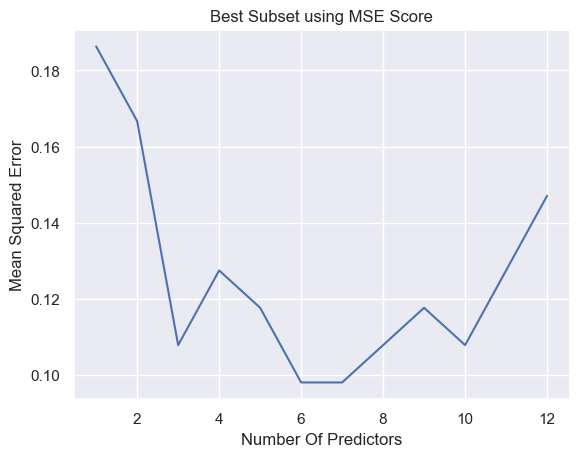

In [335]:
def calc_best_score(estimator, x_train, y_train, best_size_subset, stepwise=False):
    best_score = np.inf

    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        predictions = estimator.fit(x_train.iloc[:, list(subset)], y_train).predict(x_test.iloc[:, list(subset)])
        score = mean_squared_error(y_test, predictions)

        if score < best_score:
            best_score, best_subset = score, subset

        list_scores.append(score)
    return best_subset, best_score, list_scores

clf = RandomForestClassifier(random_state=5, n_estimators=30, bootstrap=True, oob_score=True)

best_subset, best_score, list_scores = calc_best_score(clf, x_train, y_train, best_size_subset)

plt.plot(np.arange(1, x.shape[1]+1), list_scores)
plt.ylabel("Mean Squared Error")
plt.xlabel("Number Of Predictors")
plt.title("Best Subset using MSE Score")

print([best_subset, best_score])

In [340]:
print(x.columns[list(best_subset)])

Index(['crim', 'chas', 'nox', 'rm', 'ptratio', 'lstat'], dtype='object')


We can deduce that the best subset is using 6 predictors, as it has the lowest mean squared error. these 6 predictors are: crim, chas, nox, rm, ptratio and lstat. 

5.

5a.

In [343]:
data = pd.read_csv("Carseats.csv")

shelveDummies = pd.get_dummies(data['ShelveLoc'], prefix="shelve")
urbanDummies = pd.get_dummies(data['Urban'], prefix='urban')
USDummies = pd.get_dummies(data['US'], prefix='US')

X = data.drop(['Sales'], axis=1).join(shelveDummies).join(urbanDummies).join(USDummies).drop(['ShelveLoc', 'Urban', 'US'], axis=1).iloc[:, 1:]

y=data['Sales']

5b.

In [344]:
clf = DecisionTreeRegressor(max_depth=2)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.5, random_state=5)

model = clf.fit(X_train, y_train)

predictions = model.predict(X_test)
print('Regression Tree MSE:',mean_squared_error(y_test, predictions))

Regression Tree MSE: 5.621764198731551


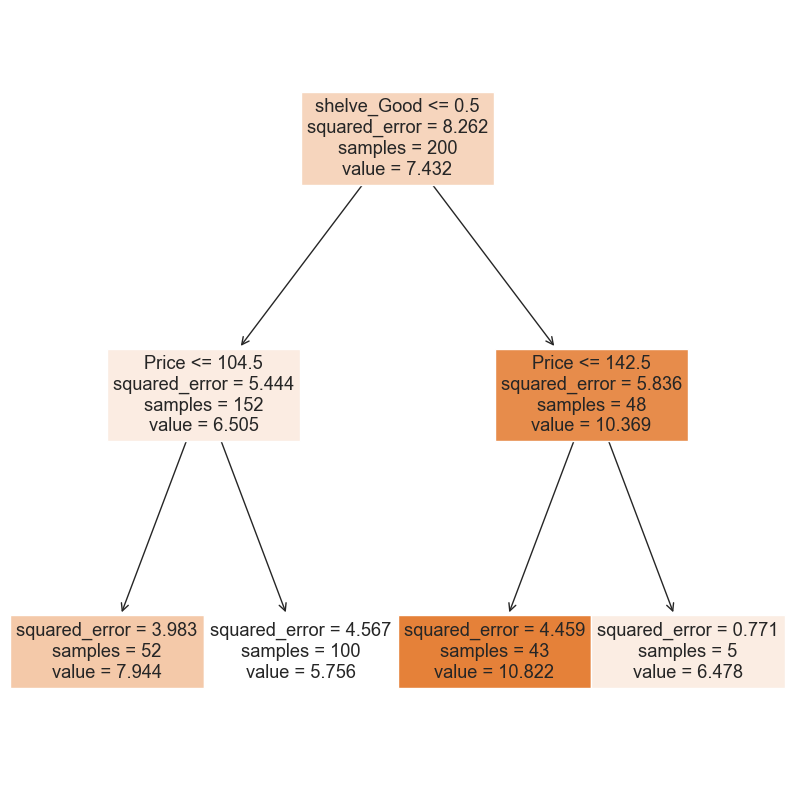

In [345]:
fig = plt.figure(figsize=(10,10))
tree_ = tree.plot_tree(clf,
                   feature_names=X.columns,
                   filled=True)

The above diagram is a regression tree with a max depth of 2, displaying deeper trees give trees with more leaves at the cost of complexity. The tree shows that the most important predictor was 'ShelveLoc', then the 'Price' variable.

5c.

Best complexity is:  6


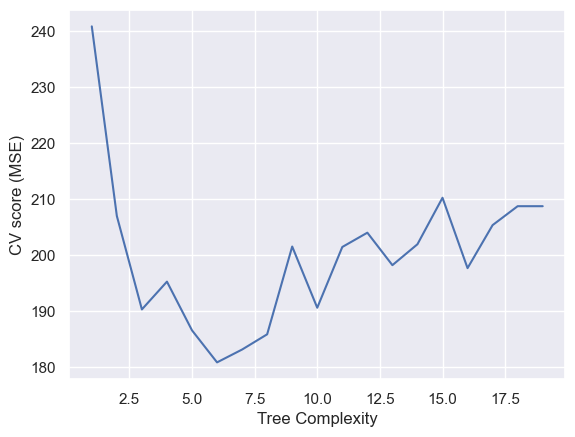

In [346]:

k = 10

kf = KFold(n_splits=k)

scores = []
best_col = 0
best_score = np.inf

maxTreeCol = 20

for a in np.arange(1,maxTreeCol):
  clf = DecisionTreeRegressor(random_state=5, max_depth=a)

  CVsum = 0
  for train_indices, test_indices in kf.split(X, y):
    predictions = clf.fit(X.iloc[train_indices], y[train_indices]).predict(X.iloc[test_indices])
    #we need MSE
    MSE = len(test_indices) * mean_squared_error(y[test_indices], predictions)
    CVsum = CVsum + MSE

  CV = CVsum / k
  scores.append(CV)

  if CV < best_score:
    best_score = CV
    best_degree = a

plt.xlabel("Tree Complexity")
plt.ylabel("CV score (MSE)")

plt.plot(range(1,maxTreeCol), scores)

print("Best complexity is: ", best_degree)

Pruning the tree does improve the test MSE. From the above graph, we can see that the optimal level of tree complexity is 6.

5d.

Bagging MSE: 2.645558313299999


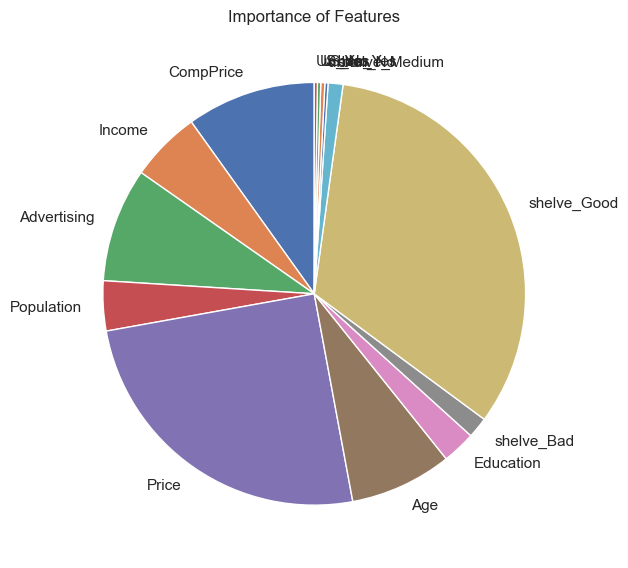

In [347]:
bagger = BaggingRegressor(random_state=5, n_estimators=100)
bagger.fit(X_train, y_train)

y_pred = bagger.predict(X_test)
print('Bagging MSE:', mean_squared_error(y_test, y_pred))

importances = np.mean([tree.feature_importances_ for tree in bagger.estimators_], axis=0)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(121)

plt.pie(importances, labels=X_train.columns.tolist(), startangle=90)

plt.tight_layout
plt.title('Importance of Features')
plt.show()


The most important measures seem to be shelve_good and Price. Our bagging MSE is 2.645558313299999

5e.

In [348]:
forest = RandomForestRegressor(random_state=5)
forest.fit(X_train, y_train.values.ravel())
pred = forest.predict(X_test)
print('Test MSE using Random Forests:', mean_squared_error(pred, y_test))

Test MSE using Random Forests: 2.673423961299999


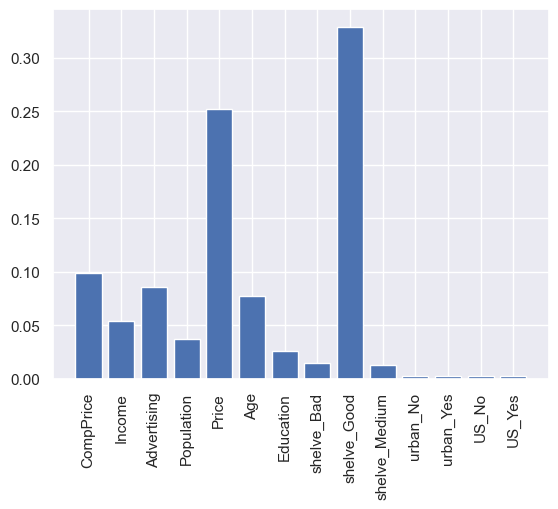

In [349]:
importance = forest.feature_importances_

plt.bar([x for x in X.columns], importance, width=0.8)
plt.xticks(rotation='vertical')
plt.show()

In [350]:
num_estimators = X.shape[1]

forest_list_mse = []
forest_best_mse = np.inf
forest_best_num_estimators = 0

for i in range(1, num_estimators):
    forest = RandomForestRegressor(random_state=5, n_estimators=100, max_features=i)
    forest.fit(X_train, y_train)

    predictions = forest.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    forest_list_mse.append(mse)
    if mse < forest_best_mse:
        forest_best_mse = mse
        forest_best_num_estimators = i

Best number of estimators is: 
11


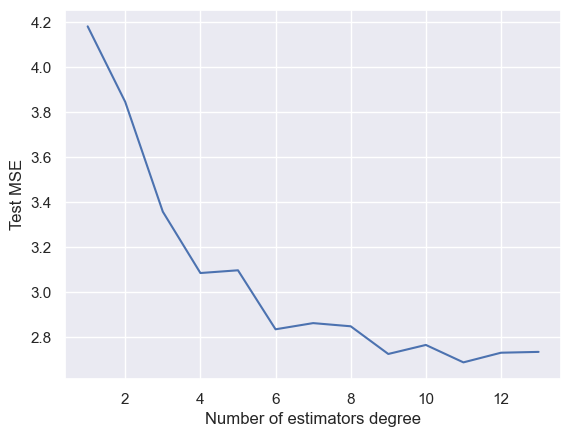

In [351]:
plt.xlabel("Number of estimators degree")
plt.ylabel("Test MSE")

plt.plot(range(1, num_estimators), forest_list_mse)

print("Best number of estimators is: ")
print(forest_best_num_estimators)

Adding more variables generally decreases the Test MSE, getting to a minimum at 11 variables.

6.
6a.

In [354]:
# Read csv
hitters = pd.read_csv('Hitters.csv')
# Drop unknown information
hitters = hitters.dropna()
# Log transform salaries
hitters['Salary'] = hitters['Salary'].apply(np.log)

# Remap everything to an integer value
hitters['League'] = hitters['League'].map({'N': 1, 'A': 0})
hitters['NewLeague'] = hitters['NewLeague'].map({'N': 1, 'A': 0})
hitters['Division'] = hitters['Division'].map({'W': 1, 'E': 0})

hitters.head(-1)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,6.163315,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,6.173786,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,6.214608,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,4.516339,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,6.620073,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,593,172,22,82,100,57,1,593,172,22,82,100,57,0,1,1222,139,15,5.105945,0
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,1,0,325,9,3,6.551080,1
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,0,0,313,381,20,6.774224,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,0,1,37,113,7,5.953243,0


6b.

In [355]:
training_set = hitters.iloc[0:200]
test_set = hitters.iloc[200:]

6cd.

C:\Users\Bernhard\AppData\Local\Temp\ipykernel_118120\1780059428.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


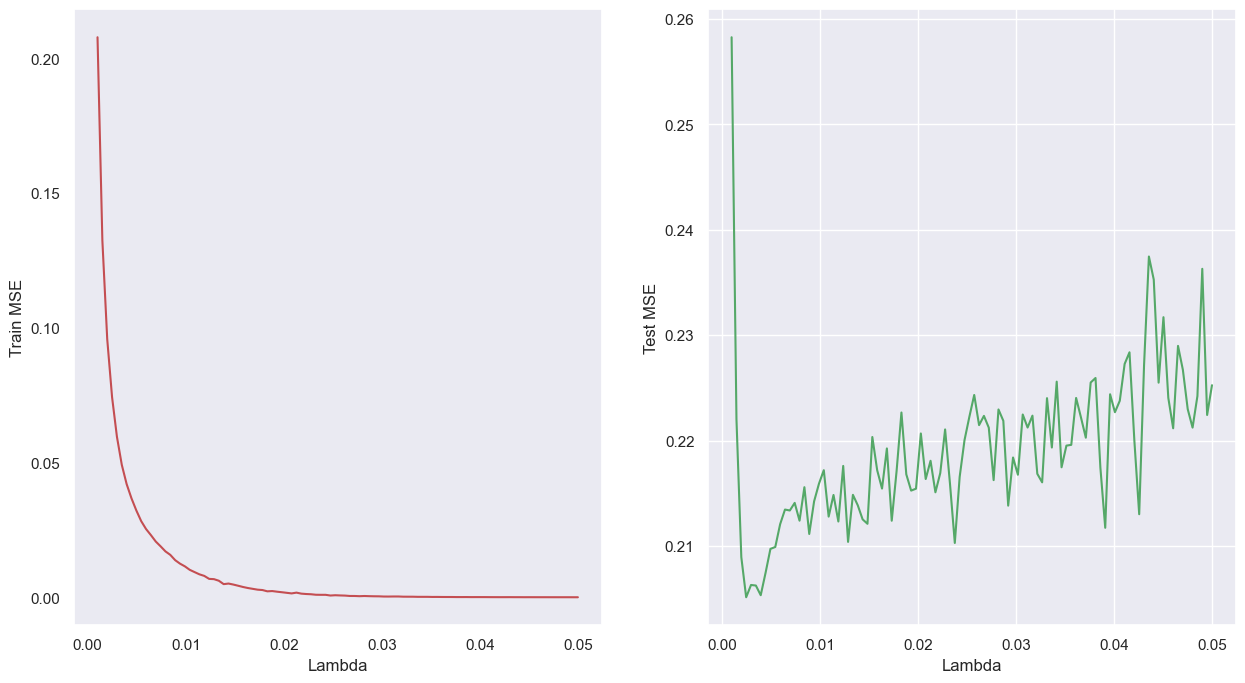

In [356]:
train_MSE = {}
test_MSE = {}

def boosting_shrinkage(X_train, Y_train, X_test, Y_test, shrinkages):

    for s in shrinkages:
        clf = GradientBoostingRegressor(random_state=5, n_estimators=1000, learning_rate=s)
        clf.fit(X_train, Y_train)
        p = clf.predict(X_train)
        train_MSE[s] = mean_squared_error(p, Y_train)
        p = clf.predict(X_test)
        test_MSE[s] = mean_squared_error(p, Y_test)
    return (train_MSE, test_MSE)

x_train = training_set.drop(['Salary'], axis=1)
x_test = test_set.drop(['Salary'], axis=1)
y_train = training_set['Salary']
y_test = test_set['Salary']

results = boosting_shrinkage(x_train, y_train.values.ravel(), x_test, y_test.values.ravel(), np.linspace(0.001, 0.05, 100))

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(121)
lists = sorted(results[0].items())
x, y = zip(*lists)
plt.plot(x, y, color='r', label='Training Error')

ax.set_xlabel('Lambda')
ax.set_ylabel('Train MSE')
ax.grid()

ax = fig.add_subplot(122)
lists = sorted(results[1].items())
x, y = zip(*lists)
plt.plot(x, y, color='g', label='Test Error')

ax.set_xlabel('Lambda')
ax.set_ylabel('Test MSE')
ax.grid()

plt.grid(b=True)
plt.show()

6e.

In [357]:
lm = LinearRegression()

lin_model = lm.fit(x_train, y_train)
lin_preds = lin_model.predict(x_test)
print("Test MSE using linear regression:", mean_squared_error(y_test, lin_preds))

parameters = {'learning_rate': np.linspace(0.001, 0.5, 20), 'n_estimators': np.arange(1, 40, 2)}
clf = GridSearchCV(ensemble.GradientBoostingRegressor(random_state=5), parameters, n_jobs=4, cv=10)
clf.fit(x_train, y_train.values.ravel())
model = clf.best_estimator_
pred = model.predict(x_test)
print("Test MSE from boosting (using lambda = 0.01):", mean_squared_error(pred, y_test))

Test MSE using linear regression: 0.49179593754549417
Test MSE from boosting (using lambda = 0.01): 0.2114150656640916


6f.

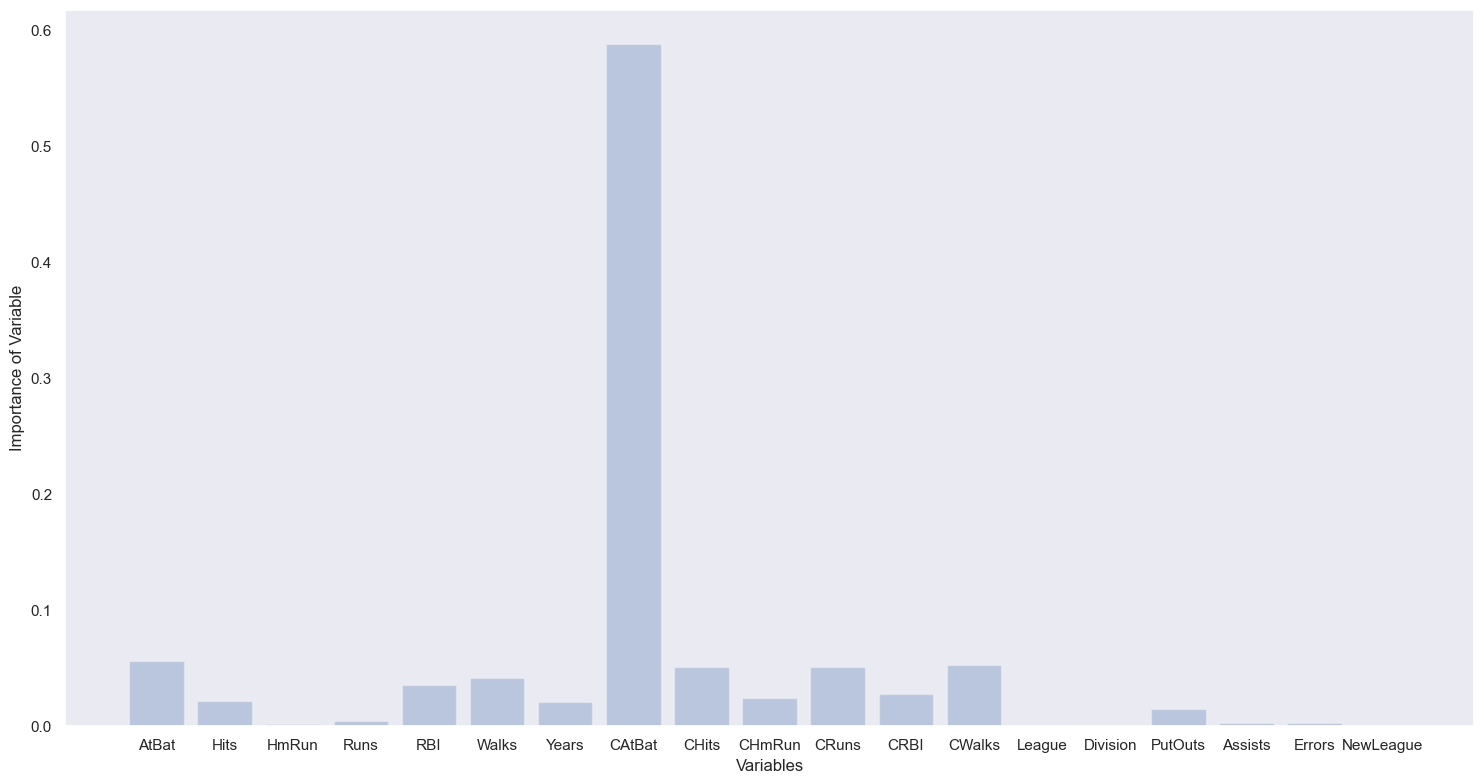

In [358]:
importances = model.feature_importances_

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
plt.bar(x_train.columns.tolist(), importances, alpha=0.3)
ax.set_xlabel('Variables')
ax.set_ylabel('Importance of Variable')
plt.grid()
plt.tight_layout()
plt.show()

CAtBat appears to have the most important predictors in the model.

6g.

In [359]:
bagging = BaggingRegressor(random_state=5)
bagging.fit(x_train, y_train.values.ravel())
bagging_pred = bagging.predict(x_test)
print("Test MSE with bagging:", mean_squared_error(bagging_pred, y_test))

Test MSE with bagging: 0.26776157258668715
